In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Expirement 3 using ELA

In [0]:
import os

from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z'

--2019-11-26 14:24:00--  https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 52.217.1.116
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|52.217.1.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375594296 (1.3G) [application/x-7z-compressed]
Saving to: ‘CASIA_ELA.zip.7z’

CASIA_ELA.zip.7z    100%[===================>]   1.28G  35.9MB/s    in 39s     

2019-11-26 14:24:39 (33.8 MB/s) - ‘CASIA_ELA.zip.7z’ saved [1375594296/1375594296]



In [5]:
!7z e CASIA_ELA.zip.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1375594296 bytes (1312 MiB)

Extracting archive: CASIA_ELA.zip.7z
--
Path = CASIA_ELA.zip.7z
Type = 7z
Physical Size = 1375594296
Headers Size = 130
Method = LZMA2:26
Solid = -
Blocks = 1

  0%      4% - CASIA_ELA.zip                      8% - CASIA_ELA.zip                     12% - CASIA_ELA.zip                     14% - CASIA_ELA.zip                     18% - CASIA_ELA.zip                     23% - CASIA_ELA.zip                     30% - CASIA_ELA.zip

In [0]:
!unzip CASIA_ELA.zip

In [3]:
path = Path("/root/.fastai/data/CASIA_ELA"); path

PosixPath('/root/.fastai/data/CASIA_ELA')

In [0]:
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', test='Test', 
                                  ds_tfms = get_transforms(do_flip=False), size=(256, 384), bs=64)

In [5]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (7605 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA;

Valid: LabelList (4163 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA;

Test: LabelList (846 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/CASIA_ELA

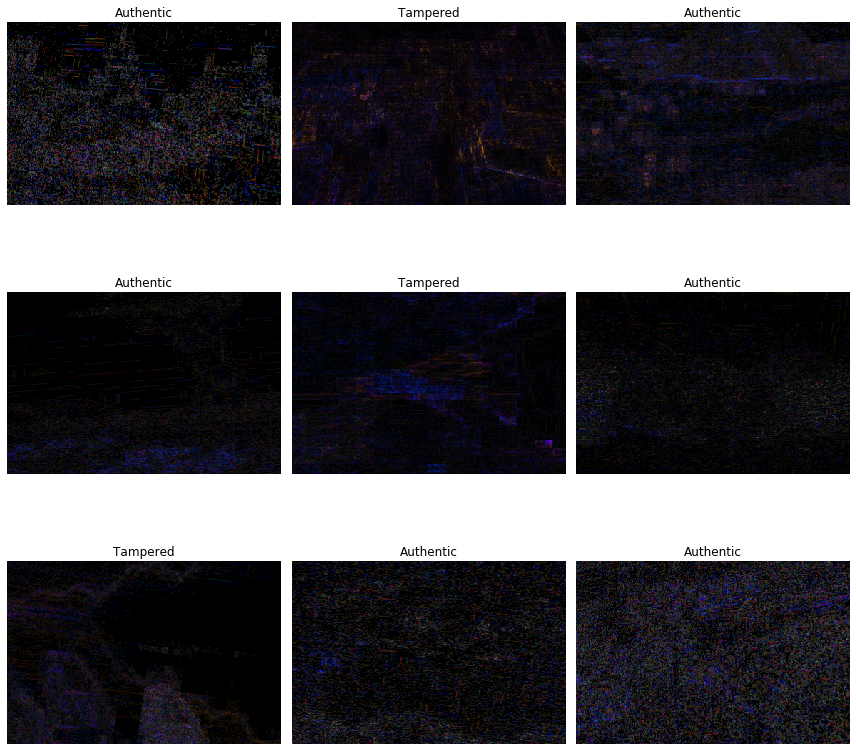

In [6]:
data.show_batch(rows=3, figsize=(12,12))

In [42]:
print(data.classes)
len(data.classes),data.c

['Authentic', 'Tampered']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


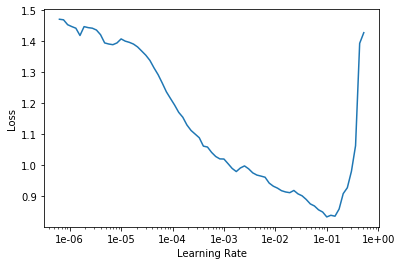

In [8]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-02

In [11]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.408174,0.327181,0.121307,02:12
1,0.293974,0.366251,0.152774,02:11
2,0.265307,0.279227,0.108335,02:12
3,0.236497,0.231946,0.096325,02:10
4,0.201569,0.251165,0.096565,02:10
5,0.187686,0.223628,0.082873,02:12
6,0.167581,0.166271,0.075426,02:09
7,0.153618,0.220899,0.083594,02:09
8,0.139031,0.193678,0.083594,02:11
9,0.124718,0.176716,0.073505,02:10


In [0]:
learn.save('ela-attempt-1-resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


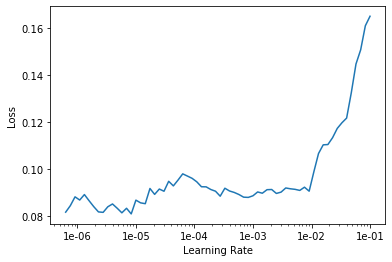

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.092943,0.160614,0.062695,02:17
1,0.110335,0.192057,0.077828,02:15
2,0.110972,0.168393,0.065337,02:17
3,0.103362,0.186071,0.074466,02:18
4,0.096595,0.159952,0.060053,02:18
5,0.080276,0.166374,0.065818,02:16
6,0.083273,0.154657,0.062935,02:15
7,0.068290,0.157276,0.061494,02:17
8,0.060803,0.159710,0.063656,02:16
9,0.050620,0.164539,0.062455,02:17


In [0]:
learn.save('ela-exp1-attempt-2-resnet50')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [17]:
interp.most_confused(min_val=2)

[('Tampered', 'Authentic', 149), ('Authentic', 'Tampered', 111)]

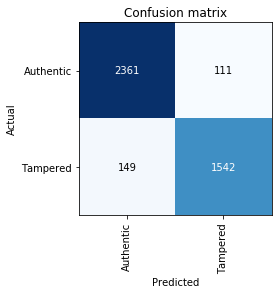

In [18]:
interp.plot_confusion_matrix()

In [0]:
learn.export()

In [0]:
learn = load_learner(path)

In [0]:
from PIL import Image, ImageChops, ImageEnhance
from pylab import *

In [0]:
def convert_to_ela(path, resaved_dir=None, quality=95):
    """Converts image by intentionally resaving an image at a known error rate and then computing the difference
    between the two images.

    Params:
    path: path to the image to be converted using ELA
    quality: quality in which to resave the image to. Defaults to 90%.
    """

    fname = path
    resaved_fname = fname.split('.')[0] + '.resaved.jpg'
    ela_fname = fname.split('.')[0] + '.ela.png'

    img = Image.open(fname).convert('RGB')
    img.save(resaved_fname, 'JPEG', quality=quality)

    img_resaved = Image.open(resaved_fname)
    ela_img = ImageChops.difference(img, img_resaved)

    # Gets the the minimum and maximum pixel values for each band in the image.
    extrema = ela_img.getextrema()

    # Calculate max different between the pixel values in the image
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)

    ela_img.save(ela_fname, 'PNG')

    return ela_img

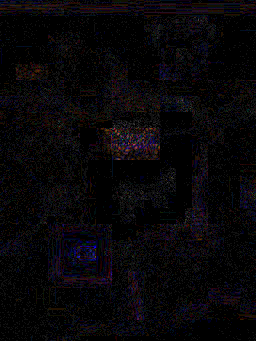

In [76]:
convert_to_ela('/content/IMG_3323_tp.jpg')

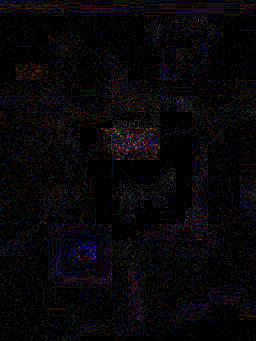

In [77]:
img = open_image('/content/IMG_3323_tp.ela.png')
img 

In [82]:
pred_class,pred_idx,confidence = learn.predict(img)
pred_class

Category Tampered

In [84]:
confidence[1]

tensor(0.9034)

In [40]:
data.train_ds

LabelList (7605 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA

In [41]:
data.valid_ds

LabelList (4163 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA

In [42]:
data.test_ds

LabelList (846 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/CASIA_ELA

In [48]:
print(len(data.train_ds))
print(len(data.valid_ds))
print(len(data.test_dl))

7605
4163
14
